### <font color='blue'> Due 11:59pm, Monday Januray 19th 2026</font>

**Runtime / setup notes:**

- This notebook does **not** require a GPU.
- If you run locally on your laptop, you must set up the Python environment first (see the repo setup docs/README).
- You can also run in **Google Colab**; if you do, install the dependencies whenever needed (e.g., `pip install gensim`).

**Total points: 100**

Welcome to STAT359!

Before you start, make sure you **read the README.md** in the github repo for important setup information. You need to install some Python libraries before you can successfully do this assignment. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning :)

If you aren't super familiar with Python, Numpy, or Matplotlib. The STAT303-1 [textbook chapters on Python/Numpy basics](https://lizhen0909.github.io/nu-stat303-1-sec20-coursebook/) are a great resource.


**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [1]:
# Imports (do not add additional imports unless instructed)
import re
import random
import pprint

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from datasets import load_dataset
from sklearn.decomposition import TruncatedSVD

random.seed(0)
np.random.seed(0)


## Word Vectors

Word vectors are a fundamental building block in NLP. They are used directly in many downstream tasks (e.g., classification, retrieval, and translation) and serve as inputs to sequence models—from early RNNs to modern Transformer-based LLMs. Because of this, it’s important to build intuition about their strengths and limitations.

In this assignment, you will explore two families of word vectors: **count-based vectors** derived from *co-occurrence matrices*, and **GloVe**, which learns embeddings from global co-occurrence statistics using a training objective.


**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

  ## Part 1: Count-Based Word Vectors (30 points)

Most word vector models start from the following idea:

> *“You shall know a word by the company it keeps.”* — ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))

Many word vector approaches rely on the intuition that **semantically similar words** tend to appear in **similar contexts**. As a result, such words often **co-occur with overlapping sets of neighboring words**. By examining these co-occurrence patterns, we can learn vector representations (embeddings) that capture aspects of meaning.

Historically, many classical methods constructed word vectors from **co-occurrence statistics**, rather than learning them through end-to-end prediction objectives. In this section, we focus on one of the most common count-based strategies: **co-occurrence matrices**.

**Further reading:**

- Jurafsky & Martin, *Speech and Language Processing* (Chapter 5): https://web.stanford.edu/~jurafsky/slp3/5.pdf
- Overview article (archived): https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285


### Co-Occurrence

A **co-occurrence matrix** counts how often tokens appear near each other. Suppose a token $w_i$ appears at position $i$ in a document. With a fixed **window size** $n$, the *context* of $w_i$ consists of the $n$ tokens immediately to the left and the $n$ tokens immediately to the right:
$$
w_{i-n},\dots,w_{i-1},\; w_{i+1},\dots,w_{i+n}.
$$
We build a word-by-word matrix $M$ where $M_{ij}$ is the number of times word $w_j$ appears in the context window of word $w_i$ (summed over the whole corpus). Many implementations make $M$ **symmetric** by counting co-occurrences in both directions; in that case $M_{ij}=M_{ji}$.

**Example (window size $n=1$)**

Document 1: `all that glitters is not gold`

Document 2: `all is well that ends well`

Below is the co-occurrence matrix for this toy corpus with window size $n=1$ (each word only "sees" its immediate left and right neighbors).

| *        | all | ends | glitters | gold | is | not | that | well |
|----------|-----|------|----------|------|----|-----|------|------|
| all      | 0   | 0    | 0        | 0    | 1  | 0   | 1    | 0    |
| ends     | 0   | 0    | 0        | 0    | 0  | 0   | 1    | 1    |
| glitters | 0   | 0    | 0        | 0    | 1  | 0   | 1    | 0    |
| gold     | 0   | 0    | 0        | 0    | 0  | 1   | 0    | 0    |
| is       | 1   | 0    | 1        | 0    | 0  | 1   | 0    | 1    |
| not      | 0   | 0    | 0        | 1    | 1  | 0   | 0    | 0    |
| that     | 1   | 1    | 1        | 0    | 0  | 0   | 0    | 1    |
| well     | 0   | 1    | 0        | 0    | 1  | 0   | 1    | 0    |

### Distance Weighting

Each row (or column) of $M$ can be viewed as a **count-based word vector**, but these vectors are typically very high-dimensional. A simple improvement is to use **distance weighting**: words that appear closer together in the window receive higher weights than those farther apart. We use the weight $w(d) = \frac{1}{d}$, where $d$ is the distance between the center word and context word. This captures the intuition that immediate neighbors are more semantically relevant than distant ones.

### PPMI Transform

With large corpora, high-frequency words and common function words (like "the", "and") may dominate the raw co-occurrence counts, obscuring meaningful semantic relationships. **Positive Pointwise Mutual Information (PPMI)** addresses this by measuring whether two words co-occur more often than expected by chance:

$$
\text{PMI}(w_i, w_j) = \log \frac{P(w_i, w_j)}{P(w_i) \cdot P(w_j)}
$$

where $P(w_i, w_j)$ is the joint probability of the two words appearing together, and $P(w_i)$, $P(w_j)$ are their individual probabilities. PPMI takes the positive part: $\text{PPMI}(w_i, w_j) = \max(0, \text{PMI}(w_i, w_j))$. This transformation reduces the influence of frequent but uninformative co-occurrences while preserving meaningful associations.

### Dimensionality Reduction

A common way to reduce dimensionality is **Singular Value Decomposition (SVD)** (closely related to PCA). In practice, we often keep only the top $k$ components (e.g., via truncated SVD) to obtain shorter vectors that capture the most important patterns in co-occurrence.

![SVD Decomposition](imgs/svd.png)

Projection doesn't create meaning—it can reveal structure that's already present in the data. After dimensionality reduction, words that appear in similar contexts (e.g., *doctor* and *hospital*) tend to be closer to each other than unrelated words (e.g., *doctor* and *dog*).

If eigenvalues and SVD are new to you, [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf) is a beginner-friendly introduction. In practice, you will typically use library implementations (NumPy/SciPy/scikit-learn). On large corpora, computing a full SVD can be expensive, so we use **truncated** methods (like `TruncatedSVD`) to efficiently extract the top $k$ components.

### Plotting Co-Occurrence Word Embeddings

In the next few cells, we’ll work with a small sample of **AG News** articles (**N_DOCS = 300**) to keep runtime reasonable. We construct a word–word co-occurrence matrix using a context window of **WINDOW_SIZE = 4**, and we discard infrequent words by keeping only those that appear at least **MIN_COUNT = 3** times.

Preprocessing is intentionally minimal: all text is **lowercased**, and tokenization keeps **alphanumeric** tokens only. No additional preprocessing steps (such as stemming, lemmatization, or stopword removal) are required for this assignment.

In [2]:
DATASET_NAME = 'ag_news'
N_DOCS = 300
WINDOW_SIZE = 4
MIN_COUNT = 3


def simple_tokenize(text):
    '''Lowercase + keep alphanumerics; return list of tokens.'''
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [t for t in text.split() if t]
    return tokens

We provide a helper function `load_corpus()` that loads a small, reproducible sample of **AG News** articles and returns them as tokenized documents.

You do **not** need to apply any additional preprocessing for this assignment.

In [3]:
def load_corpus(dataset_name=DATASET_NAME, n_docs=N_DOCS, seed=0):
    '''Load and tokenize a small corpus for this assignment.'''
    ds = load_dataset(dataset_name, split='train')
    rng = random.Random(seed)
    indices = list(range(len(ds)))
    rng.shuffle(indices)
    indices = indices[:n_docs]
    docs = []
    for i in indices:
        text = ds[i]['text']
        docs.append(simple_tokenize(text))
    return docs

Let’s inspect a few processed reviews to see what the tokenized documents look like.

In [4]:
corpus = load_corpus()
print('num documents:', len(corpus))
print('tokens in first document:', len(corpus[0]))
print('first 40 tokens:', corpus[0][:40])

num documents: 300
tokens in first document: 106
first 40 tokens: ['xerces', '2', '6', '1', 'and', 'bom', 'xml', 'which', 'is', 'utf', '16', 'encoded', 'is', 'supposed', 'to', 'have', 'a', 'prolog', 'first', 'two', 'bytes', 'called', 'a', 'bom', 'of', 'ff', 'fe', 'to', 'signal', 'that', 'the', 'feed', 'you', 're', 'about', 'to', 'parse', 'is', 'multibyte', 'the']


### Question 1.1: Build a vocabulary with a minimum count [code] (6 points)

Write a function that builds a vocabulary from `corpus` (a list of token lists).

Requirements:
- Count token frequencies across all documents.
- Keep tokens that appear at least `min_count` times.
- Return `vocab` as a **sorted list** and `word2id` as a mapping token -> index.


In [5]:
def build_vocab(corpus, min_count=MIN_COUNT):
    '''Return (vocab, word2id, counts) where vocab is sorted.'''
    counts = {}

    # ------------------
    # TODO: This function is mostly implemented for you.
    # You only need to fill in ONE missing line below.
    # ------------------
    for doc in corpus:
        for tok in doc:
            counts[tok] = counts.get(tok, 0) + 1

    vocab = sorted([w for w, c in counts.items() if c >= min_count])

    # TODO: Build the token -> index mapping for vocab (1 line).
    word2id = {w: i for i, w in enumerate(vocab)}

    return vocab, word2id, counts

In [6]:
# Sanity check (deterministic toy corpus)
toy = [['a','b','a'], ['b','c'], ['a','c','c']]
vocab_toy, word2id_toy, counts_toy = build_vocab(toy, min_count=2)
assert vocab_toy == ['a', 'b', 'c']
assert counts_toy['a'] == 3 and counts_toy['b'] == 2 and counts_toy['c'] == 3
assert word2id_toy == {'a': 0, 'b': 1, 'c': 2}
print('Passed toy vocab test.')


Passed toy vocab test.


### Question 1.2: Distance-weighted co-occurrence counts [code] (8 points)

We define a context window of size `window_size`. For each center token, look at tokens within that window.
Add a contribution to the co-occurrence count that is larger for closer words.

Use the weight: weight(d) = 1/d where d = |i-j|.

Requirements:

- Only count words that are in `word2id`.
- Return a **square** NumPy array `C` of shape `(V, V)`.
- Make `C` symmetric by adding both directions (center->context and context->center).

In [7]:
def weighted_cooccurrence(corpus, word2id, window_size=WINDOW_SIZE):
    '''Return symmetric weighted co-occurrence matrix C (float64).'''
    V = len(word2id)
    C = np.zeros((V, V), dtype=np.float64)

    # ------------------
    # TODO: The loops and indexing are provided.
    # You only need to add the distance-weighted update (2-3 lines).
    # Use weight(d) = 1/d where d = |i-j|.
    # ------------------
    for doc in corpus:
        n = len(doc)
        for i in range(n):
            wi = doc[i]
            if wi not in word2id:
                continue
            ui = word2id[wi]
            j_max = min(n, i + window_size + 1)
            for j in range(i + 1, j_max):
                wj = doc[j]
                if wj not in word2id:
                    continue
                vj = word2id[wj]

                # TODO: compute distance d, weight w=1/d, and update BOTH C[ui,vj] and C[vj,ui].
                d = j - i
                w = 1 / d
                C[ui, vj] += w
                C[vj, ui] += w

    return C


In [8]:
# Small checks for weighted co-occurrence
toy = [['a','b','c','b']]
vocab_toy, word2id_toy, _ = build_vocab(toy, min_count=1)
C = weighted_cooccurrence(toy, word2id_toy, window_size=2)
assert C.shape == (3,3)
assert np.allclose(C, C.T)
print('Passed basic co-occurrence checks.')

Passed basic co-occurrence checks.


### Question 1.3: PPMI transform [code] (6 points)

Raw co-occurrence counts are dominated by very frequent tokens. A common fix is to convert counts into
PPMI (positive pointwise mutual information).

Implement `ppmi(C)` to return a matrix of the same shape. Use a small epsilon to avoid divide-by-zero.

In [9]:
def ppmi(C, eps=1e-12):
    '''Convert co-occurrence matrix C to PPMI matrix.'''
    # ------------------
    # TODO: Most of this is implemented for you.
    # You only need to fill in the PMI->PPMI step (2 lines).
    # ------------------
    C = np.asarray(C, dtype=np.float64)
    total = float(C.sum())
    if total <= 0:
        return np.zeros_like(C)

    row_sums = C.sum(axis=1, keepdims=True)
    col_sums = C.sum(axis=0, keepdims=True)

    p_uv = C / total
    p_u = row_sums / total
    p_v = col_sums / total

    denom = p_u @ p_v

    # TODO: compute PMI = log((p_uv + eps) / (denom + eps))
    # TODO: return PPMI = max(PMI, 0) (elementwise)
    
    PMI = np.log((p_uv + eps) / (denom + eps))
    PPMI = np.maximum(PMI,0)
    return PPMI

In [10]:
# PPMI sanity check: output nonnegative and same shape
C_small = np.array([[0., 1.], [1., 0.]])
P_small = ppmi(C_small)
assert P_small.shape == (2,2)
assert np.all(P_small >= 0)
print('Passed basic PPMI checks.')

Passed basic PPMI checks.


### Question 1.4: Reduce and plot a 2D embedding [code] (6 points)

In this question, you will implement the dimensionality-reduction function `reduce_2d` yourself.
Use `TruncatedSVD` to reduce your PPMI matrix to 2D, then plot selected words with labels.

Requirements:

- `reduce_2d` must create a `TruncatedSVD` model with `n_components=2` and return an array of shape `(V, 2)` (or more generally `(n_rows, 2)`).
- You should use `fit_transform` (or `fit` + `transform`) rather than computing SVD manually.
- `plot_words_2d` plots only the requested words (skip words not in the vocab).


In [11]:
def reduce_2d(X, n_iter=10, random_state=0):
    '''Return 2D embedding from matrix X using truncated SVD.'''
    # ------------------
    # TODO: Implement this function.
    #
    # Requirements:
    # - Use TruncatedSVD from sklearn.decomposition (already imported).
    # - Use n_components=2, and pass through n_iter and random_state.
    # - Return Z with shape (X.shape[0], 2).
    #
    # Hint: svd.fit_transform(X) returns the reduced representation.
    # ------------------
    svd = TruncatedSVD(n_components=2, n_iter=n_iter, random_state=random_state)
    Z = svd.fit_transform(X)
    return Z


In [12]:
def plot_words_2d(Z, word2id, words, title=None):
    '''Scatter plot for selected words; skip missing words.'''
    # ------------------
    # TODO: Only fill in the missing parts in the loop below.
    # ------------------
    xs = []
    ys = []
    labels = []

    for w in words:
        idx = word2id.get(w)
        if idx is None:
            continue

        # TODO: append x and y coordinates from Z, and the label w
        xs.append(Z[idx, 0])
        ys.append(Z[idx, 1])
        labels.append(w)

    plt.figure()
    plt.scatter(xs, ys, alpha=0.8)
    for x, y, w in zip(xs, ys, labels):
        plt.annotate(w, (x, y), textcoords="offset points", xytext=(4, 2), ha="left")

    if title is not None:
        plt.title(title)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
    return


--------------------------------------------------------------------------------
Outputted Plot:


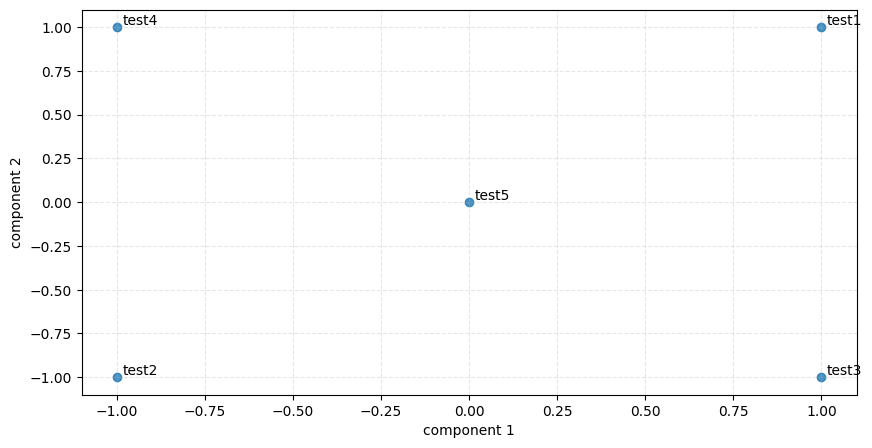

--------------------------------------------------------------------------------


In [13]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the included file question_1.4_test.png
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_words_2d(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-occurrence embedding analysis [written] (4 points)

**Run the cell below to generate the plot.** It may take a few minutes to compute the co-occurrence matrix and run SVD (depending on your machine).
After the plot is generated, answer the interpretation prompt in the next markdown cell.

vocab size: 871


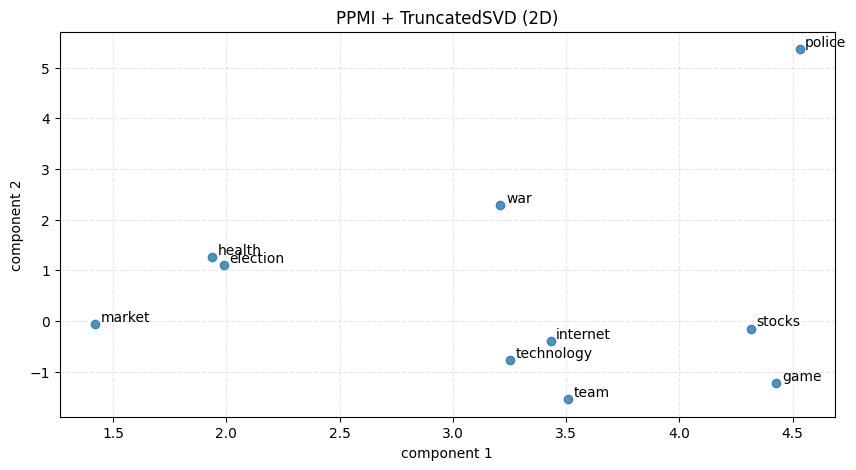

In [14]:
# Build Part 1 embeddings (this may take ~1-3 minutes depending on your machine)
vocab, word2id, counts = build_vocab(corpus, min_count=MIN_COUNT)
print('vocab size:', len(vocab))
C = weighted_cooccurrence(corpus, word2id, window_size=WINDOW_SIZE)
P = ppmi(C)
Z2 = reduce_2d(P)

words_to_plot = ['market', 'stocks', 'game', 'team', 'war', 'election', 'police', 'technology', 'internet', 'health']
plot_words_2d(Z2, word2id, words_to_plot, title='PPMI + TruncatedSVD (2D)')

#### Interpretation

Look at your Part 1 plot. In 4-6 sentences:
- describe one cluster you see (which words are near each other?),
- propose a reason based on news topics/contexts,
- name one surprising placement and give a plausible explanation.

#### One cluster I observe consists of “internet,” “technology,” and “team.” This cluster is reasonable because the internet is a form of technology, and internet-related articles often discuss new technological developments. Also, “team” may appear close to these words because many sports articles are published and discussed online. A surprising placement is “market,” since it could be related to “stocks” in financial news or “game” in the context of the video game market. However, “market” appears closer to “health,” which suggests the healthcare markets. One plausible explanation is that this corpus emphasizes health and political topics, which make “market” to be more associated with health instead of finance or gaming.

## Part 2: Prediction-Based Word Vectors (65 points)

In Part 1 you built **count-based** word vectors from a co-occurrence matrix. In Part 2, we’ll look at **prediction-based** embeddings—vectors learned by optimizing an objective function on large text corpora. Two classic examples are **word2vec** and **GloVe**.

In this assignment we will explore **pretrained GloVe embeddings**. GloVe uses global co-occurrence statistics during training, but the final vectors are learned (not raw counts). You do **not** need to train GloVe yourself—we will load a pretrained **100-dimensional** GloVe model using `gensim`.

**Runtime notes:**

- The first time you run the loading cell, it will download the model and may take a few minutes.
- If you have downloaded it before, rerunning the cell will load from the local cache and should be faster.

In [15]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each length 100
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-100")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings

Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 40000 GloVe vectors instead.
Run the following cells to:

1. Put 40000 Glove vectors into a matrix M
2. Run `reduce_2d` (your Truncated SVD function) to reduce the vectors from 100-dimensional to 2-dimensional.

In [16]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 100) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [17]:
# -----------------------------------------------------------------
# Run Cell to Reduce 100-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words_to_plot)
M_reduced = reduce_2d(M, n_iter=10, random_state=0)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 400000 words into word2ind and matrix M...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe plot analysis [written] (7 points)

Run the cell below to plot the 2D GloVe embeddings for the same words as question 1.5. Then answer:

* Describe one direction or axis you observe (what changes along it?).
* Name one word that seems out of place and propose a reason.

1. Along the component 2, words in top are more related to public and political topics, and words in the bottom are more related to technology, online related topics.
2. The word “stocks” seems out of place because it is quite far away to related words like “market”, "technology". One possible reason will be “stocks” is being used in a more specialized financial contexts than other words, so this lead to GloVe plot to isolates stocks in the bottom.

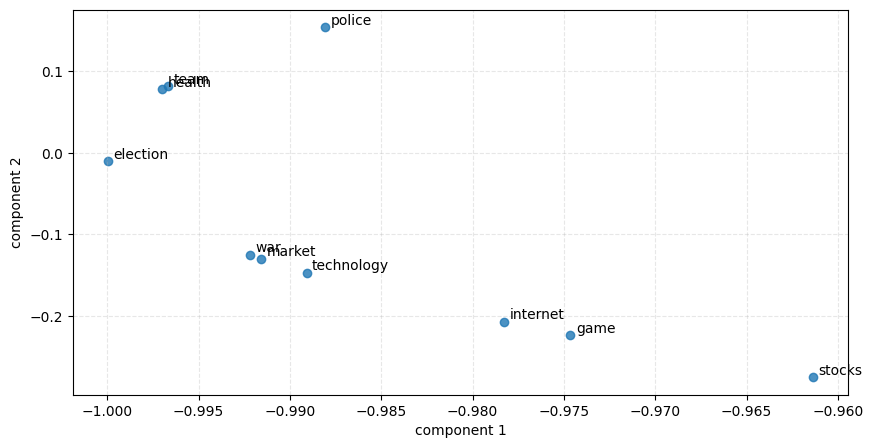

In [18]:

# plot the same words as question 1.5
plot_words_2d(M_reduced_normalized, word2ind, words_to_plot)

a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

#### One way the GloVe plot is different is that many words such as "war", "technology", "technology" shift left along component 1, and words are clustered in the left along component 1 axis compare to the co-occurrence matrix. One way that is similar is that semantically words such as "internet" and "game" are still close to each other.</font>

b. Why might the GloVe plot (question_2.1.png) differ from the plot generated earlier from the co-occurrence matrix (question_1.5.png)?

#### The GloVe plot is differ from plot of the co-occurrence matrix because GloVe embeddings are pretrained on a large external corpus in a prediction-based embeddings. This will allow GloVe to have a more general semantic relationships. The co-occurrence matrix plot is based on a smaller dataset, which relies on local co-occurrence counts. Thus, this difference might lead to different patterns in plots.</font>

### Cosine Similarity

Now that we have word vectors, we need a way to quantify how **similar** two words are according to their vectors. A standard choice is **cosine similarity**, which compares the *angle* between two vectors (so it focuses on direction rather than raw length). We’ll use it throughout Part 2 to find words that are “close” or “far” in the pretrained GloVe space.

You can think of $n$-dimensional vectors as points in $\mathbb{R}^n$. Distances such as [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) measure how far apart points are, but cosine similarity instead measures how aligned the vectors are:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the angle $\Theta$ explicitly, we use $\cos(\Theta)$. Formally, the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is:

$$
s = \frac{p \cdot q}{\lVert p \rVert\, \lVert q \rVert}, \qquad s \in [-1, 1]
$$

- $s \approx 1$: very similar directions (often semantically related).
- $s \approx 0$: roughly unrelated directions.
- $s \approx -1$: opposite directions (not necessarily antonyms in practice).

**Cosine distance** is defined as $1 - s$ and is what `wv_from_bin.distance(w1, w2)` returns.

### Question 2.2: Words with multiple senses [code + written] (6 points)
Polysemes and homonyms have more than one meaning. Find a word with *at least two different senses* such that the top-10 most similar words (by cosine similarity) include related words from *both* senses. You will likely need to try several candidates.

State the word you found and the two meanings reflected in the top 10. Why do many candidate words fail (i.e., the top-10 list reflects only one sense)?

**Note**: Use `wv_from_bin.most_similar(word)` to get the top 10 most similar words. For details, see the [GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar).


In [19]:
# ------------------
# Write your implementation here.
#
# Tip: You will probably need to try multiple candidate words.
# The helper below makes it easier to inspect nearest neighbors.
# ------------------

def top_similar(model, word, topn=10):
    """Return and print top-n most similar words (cosine similarity)."""
    try:
        sims = model.most_similar(word, topn=topn)
    except KeyError:
        print(f"'{word}' is not in the vocabulary.")
        return []
    print(f"Top {topn} most similar to '{word}':")
    for w, s in sims:
        print(f"  {w:20s} {s:.4f}")
    return sims

# Example usage (replace with your own search):
candidates = ['light', 'tesla', 'plant']  # try a few polysemous words
for c in candidates:
    print('-' * 60)
    top_similar(wv_from_bin, c)

# ------------------

------------------------------------------------------------
Top 10 most similar to 'light':
  dark                 0.7223
  bright               0.7072
  lights               0.6818
  air                  0.6545
  blue                 0.6505
  visible              0.6494
  color                0.6491
  sky                  0.6486
  heavy                0.6446
  water                0.6385
------------------------------------------------------------
Top 10 most similar to 'tesla':
  volt                 0.6091
  nvidia               0.5855
  motors               0.5744
  mazda                0.5551
  isuzu                0.5490
  ev1                  0.5206
  roadster             0.5152
  gpu                  0.5108
  kia                  0.5106
  motorola             0.5093
------------------------------------------------------------
Top 10 most similar to 'plant':
  plants               0.8918
  factory              0.7068
  farm                 0.6554
  facility             0.6538
 

#### The word I found will be "plant", this word have at least two meanings: 1. agriculture(farm) 2.industry (factory), which GloVe caputres both meaning. The reason why many words fail is because GloVe is pretrained. If a word have much more statistically dominant meaning in the dataset, then the embeddings will close to the dominant meaning of that word.

### Question 2.3: Synonyms vs. antonyms [code + written] (4 points)

Cosine Distance is defined as 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

Example (do not reuse): $w_1$="fast", $w_2$="quick", $w_3$="slow" might show this effect. Provide your own example and a short explanation for why the counter-intuitive result can happen.

Use `wv_from_bin.distance(w1, w2)` to compute cosine distance. See the [GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance).


In [20]:
# ------------------
# Write your implementation here.
#
# You want synonyms (w1, w2) and an antonym (w1, w3) such that:
#   distance(w1, w3) < distance(w1, w2)
# where distance = 1 - cosine_similarity.
# ------------------

def show_cosine_distances(model, w1, w2, w3):
    """Print cosine distances for (w1,w2) and (w1,w3)."""
    try:
        d12 = float(model.distance(w1, w2))
        d13 = float(model.distance(w1, w3))
    except KeyError as e:
        print(f"Word not in vocabulary: {e}")
        return None
    print(f"d({w1}, {w2}) = {d12:.4f}")
    print(f"d({w1}, {w3}) = {d13:.4f}")
    print("Condition d(w1,w3) < d(w1,w2):", d13 < d12)
    return d12, d13

# Example usage (replace with your own words):
w1, w2, w3 = 'large', 'big', 'small'
show_cosine_distances(wv_from_bin, w1, w2, w3)

d(large, big) = 0.2918
d(large, small) = 0.0667
Condition d(w1,w3) < d(w1,w2): True


(0.2917943000793457, 0.06665772199630737)

#### This counter-intuitive result can happen because word embedding are based on contextual similarity not semantic meaning. Antonyms such as large and small are often used in similar context to describe a size of an object, so the vector will be closer. Synonyms may be used in different situations which make them to be far away to each other.</font>

### Question 2.4: Analogies with word vectors [written] (6 points)

Word vectors can sometimes solve analogies using **vector arithmetic**.

In this question, we will use the classic analogy form:

> $x : y \;::\; a : b$

Intuitively, we are asking for a word $b$ such that the relationship “from $x$ to $y$” is similar to the relationship “from $a$ to $b$”. In embedding space, this is often modeled as:

$$
\text{vector}(b) \approx \text{vector}(y) - \text{vector}(x) + \text{vector}(a).
$$

Run the cell below to see the model’s top candidates for the analogy **man : grandfather :: woman : ?**.

**How `most_similar` is used:** `most_similar(positive=[...], negative=[...])` returns words that are close to the sum of the positive vectors and far from the sum of the negative vectors (by cosine similarity).

In [21]:
# Run this cell to answer the analogy: man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.8358322978019714),
 ('granddaughter', 0.8109342455863953),
 ('mother', 0.7872799038887024),
 ('daughter', 0.7718198299407959),
 ('niece', 0.7682032585144043),
 ('father', 0.7500689625740051),
 ('grandson', 0.7489057183265686),
 ('grandparents', 0.738144040107727),
 ('wife', 0.7305439710617065),
 ('aunt', 0.7243596315383911)]


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the (unknown) answer, respectively.

The call below searches over candidate words $x$ and returns those with the **highest cosine similarity** to a *target vector* formed by adding the `positive` vectors and subtracting the `negative` vectors:

```python
wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man'])
```

Using **only** $m$, $g$, $w$ and the operators $+$ and $-$, write the target vector that candidates are compared to. Then state the cosine-similarity objective in symbols (e.g., “maximize $\cos(\cdot,\cdot)$ …”).

Hint: The target vector is $w + g - m$.

#### The target vector is $w+g-m$, w stands for woman, g stands for grandfather, and m stands for man. The objective is to find a word which have highest cosine similarity with this target vector. The result is grandmother. This make sense because $g-m$ caputre the concept of being older, then adding it to woman which results grandmother. </font>

### Question 2.5: Interpreting analogy results [code + written] (7 points)

**(a) (2 points)** In Question 2.4, `most_similar` often returns several *related* words (e.g., “granddaughter”, “daughter”, “mother”), not just one “perfect” answer.

In 2–4 sentences, explain **why multiple answers can be reasonable**. Your explanation should reference at least one of the following ideas:
- the analogy query produces a *target vector* and returns the nearest neighbors to that vector (not a single “proof”),
- several words may be similarly close in cosine similarity,
- the relationship you are asking for (e.g., “female counterpart of a family role”) is not uniquely represented by one word in the embedding space,
- vocabulary / corpus effects (what the model saw during training).

#### Multiple answers can be reasonable because the analogy query creates a target vector, and by using most_similar this will return the nearestneighbors to that vector, so this will not lead to a single answer. Several words can have close cosine similarity to the target vector such as, granddaughter, mother, grandmother, since they all have the relation of females in family-role. These roles is not uniquely represented by only one direction in embedding space, for example granddaughter means younger, and grandmother means older which is opposite way. Lastly, the training corpus affect which related words appear near the target.   </font>

**(b) (5 points)** Find an analogy that **does** hold for these vectors (i.e., the intended word is ranked #1).

In your solution, state the full analogy in the form **x : y :: a : b** and briefly explain (1–2 sentences) why it makes sense.

**Tips:**
- You may need to try several analogies before you find one that works.
- Pick words that are common in Wikipedia/news-style text (the kind of data GloVe was trained on).
- You can use the helper in the next cell to print the top candidates and verify that your intended $b$ is ranked #1.

In [22]:
# Choose an analogy x:y :: a:b that the embeddings solve correctly (b is ranked #1).
# For example: x, y, a, b = ("", "", "", "")

def check_analogy(model, x, y, a, b, topn=10):
    """Print the top candidates for y - x + a and check if b is ranked #1."""
    res = model.most_similar(positive=[a, y], negative=[x], topn=topn)
    print(f"Analogy: {x}:{y} :: {a}:{b}")
    print("Top candidates:")
    for w, s in res:
        print(f"  {w:20s} {s:.4f}")
    print("Top-1 prediction:", res[0][0])
    return res

# ------------------
# Write your implementation here.
# 1) Set x, y, a, b to define your analogy.
# 2) (Optional) Call check_analogy(...) to inspect the top candidates.
# ------------------

x, y, a, b = ("italy", "rome", "france", "paris")

# Optional sanity check before the assert:
_ = check_analogy(wv_from_bin, x, y, a, b, topn=10)

# ------------------

# Test the solution (b must be ranked #1)
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

Analogy: italy:rome :: france:paris
Top candidates:
  paris                0.8440
  prohertrib           0.6639
  strasbourg           0.6326
  french               0.6323
  brussels             0.6249
  london               0.6063
  lyon                 0.5853
  saint                0.5806
  le                   0.5784
  gaulle               0.5758
Top-1 prediction: paris


#### Rome is the capital of Italy, and Paris is the capital of France. This analogy is about geography, which is commonly mentioned in Wikipedia, so GloVe embeddings can capture this relationship. </font>

### Question 2.6: When analogies go wrong [code + written] (7 points)

Analogy solving with embeddings is *suggestive*, not guaranteed. The vector arithmetic $y - x + a$ can fail when relationships are not represented cleanly in the training data or when a word has multiple strong associations.

**(a) (2 points)** Below, we try to solve the analogy **hand : glove :: foot : sock** using:
$$
\text{sock} \;\approx\; \text{foot} - \text{hand} + \text{glove}.
$$

Run the cell and look at the top candidates. In 2–4 sentences, give a plausible reason the intended answer might not be ranked #1. Your explanation should reference at least one of these ideas:
- the training corpus may not strongly encode the “wears/used-with” relation in a consistent direction,
- words like *glove* and *sock* have other associations (sports, materials, idioms, etc.),
- analogies work best for certain relation types (e.g., country–capital, singular–plural),
- noise from nearest-neighbor search / multiple near-ties.

In [23]:
# Analogy query: hand : glove :: foot : ?
# i.e., glove - hand + foot
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('fairway', 0.5142220854759216),
 ('infield', 0.511544942855835),
 ('elbow', 0.4750414490699768),
 ('fielder', 0.46841347217559814),
 ('footed', 0.4630338251590729),
 ('flagstick', 0.45926135778427124),
 ('bunker', 0.45731121301651),
 ('outfield', 0.45624253153800964),
 ('1,800-square', 0.454319030046463),
 ('freekick', 0.4536673128604889)]


#### The top results of analogy query are all sports-field words, this indicates that the embedding is associating foot+glove in a sports context than wear on clothing context. So, this can result the nearest neighbors not equal sock. In addition, the relation of hand to glove and foot to sock may not seen as a clean direction, because glove is more sports wear, and socks is more daily essential clothing, so vector gets noisy and nearby sports- related neighbors will outrank sock. </font>

**(b) (5 points)** Find another analogy that does **not** hold according to these vectors.

In your solution:

- State the *intended* analogy in the form **x : y :: a : b** (where $b$ is what a human would expect).
- Compute the model’s top-1 prediction $\hat{b}$ for the query `most_similar(positive=[a, y], negative=[x])`.
- Report the incorrect prediction $\hat{b}$ (and optionally the top-5 list) and briefly explain (1–2 sentences) why the model might prefer $\hat{b}$ over $b$.

Tip: Choose a relationship that is subtle, culturally specific, or not consistently expressed in text.

In [24]:
# Find an analogy x:y :: a:b that the embeddings get wrong (b is NOT ranked #1).
# For example: x, y, a, b = ("", "", "", "")

def show_analogy_results(model, x, y, a, topn=10):
    """Print top-n candidates for y - x + a and return the result list."""
    res = model.most_similar(positive=[a, y], negative=[x], topn=topn)
    print(f"Analogy query: {x}:{y} :: {a}: ?")
    for w, s in res:
        print(f"  {w:20s} {s:.4f}")
    return res

# ------------------
# Write your implementation here.
# 1) Set x, y, a, b for your intended analogy x:y :: a:b.
# 2) Call show_analogy_results(...) and store the model's top-1 prediction in b_hat.
# ------------------

x, y, a, b = ("teacher", "classroom", "chef", "kitchen")

res = show_analogy_results(wv_from_bin, x, y, a, topn=10)
b_hat = res[0][0]  # model's (incorrect) prediction
print("intended analogy b", b)
print("Model top-1 b_hat:", b_hat)
# ------------------
# Print the full ranked list (provided starter behavior)
pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))

# Test: the model should NOT rank your intended b at #1
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] != b

Analogy query: teacher:classroom :: chef: ?
  dining               0.6946
  kitchen              0.6605
  menus                0.6593
  menu                 0.6452
  kitchens             0.6260
  chefs                0.6229
  gourmet              0.6033
  restaurant           0.5867
  diners               0.5615
  dishes               0.5601
intended analogy b kitchen
Model top-1 b_hat: dining
[('dining', 0.6945967078208923),
 ('kitchen', 0.6605265140533447),
 ('menus', 0.6593088507652283),
 ('menu', 0.6452091932296753),
 ('kitchens', 0.6259853839874268),
 ('chefs', 0.6228706240653992),
 ('gourmet', 0.6032628417015076),
 ('restaurant', 0.5866550803184509),
 ('diners', 0.5614819526672363),
 ('dishes', 0.5600732564926147)]


#### The model prefer dining over kitchen because chef is strongly associated with food,restaurant, and menu context. So, the vector of classroom - teacher + chef cause the nearest neighbor to will more closely with general dining rather than the workplace kitchen.</font>

### Question 2.7: Guided analysis of bias in word vectors [written] (6 points)

Word embeddings can encode **societal biases** present in their training data. This question asks you to *observe and describe* patterns in the pretrained vectors—not to endorse them.

Run the cell below. It produces two lists of nearest neighbors for analogy-style queries that differ only by swapping `man` and `woman`:

- Query A: similar to `man` and `profession`, dissimilar to `woman`
- Query B: similar to `woman` and `profession`, dissimilar to `man`

In **4–6 sentences**, compare the two lists and answer:

- What differences do you notice in the types of occupations/terms suggested?
- What do those differences suggest about the associations the embeddings have learned?
- Give **one** plausible explanation for where such bias could come from (think training data + objective).

Note: Individual terms may be noisy. Focus on overall patterns (e.g., recurring themes or categories).

In [25]:
# Run this cell
# Here `positive` indicates words we want to be similar to, and `negative` indicates words we want to be dissimilar from.
# As you inspect the outputs, look for broad patterns (e.g., recurring occupations, stereotypes, or themes).

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('practice', 0.6156836152076721),
 ('knowledge', 0.6129590272903442),
 ('teaching', 0.5949095487594604),
 ('skill', 0.5886170864105225),
 ('reputation', 0.588079571723938),
 ('philosophy', 0.5868663191795349),
 ('work', 0.5848590135574341),
 ('skills', 0.5772278904914856),
 ('discipline', 0.576593816280365),
 ('mind', 0.5739314556121826)]

[('professions', 0.6473134756088257),
 ('practitioner', 0.5966603755950928),
 ('nursing', 0.5942842364311218),
 ('vocation', 0.5698666572570801),
 ('teaching', 0.5623518824577332),
 ('childbirth', 0.543552815914154),
 ('academic', 0.5408717393875122),
 ('teacher', 0.5401058197021484),
 ('educator', 0.5207306742668152),
 ('qualifications', 0.5143449902534485)]


#### The man + profession query is more related to abstract and intellectual terms such as "philosophy", "knowledge", "reputation". THese words emphasize skills and intellectual attributes. In contrast, the women + profession query contains word like "nursing", "teacher", "educator", which highly related to  caregiving work. This indicates that the embeddings have learned the gender assoiatioassociation, which links abstract with men and women with more educational and nurturing role job. One plausible explanation is that the training data contains biased patterns of men and women in professional contexts, as GloVe learns from global word co-occurrence statistics, thus biases are encoded into the vector space, which results the difference and bias result above.  </font>

### Question 2.8: Independent analysis of bias in word vectors [code + written] (6 points)

In Question 2.7 you analyzed a provided example. Here you will design your **own** query that reveals a biased association learned by the pretrained embeddings.

**Task:** Use `wv_from_bin.most_similar(positive=[...], negative=[...])` to create a pair of analogy-style queries that are identical except for swapping one word (e.g., swapping a demographic term), and compare the results.

In your submission:

- Show the code you ran and the top results it produced (top-10 is fine).
- In 3–5 sentences, describe the pattern you observe and explain why you consider it biased or stereotyped.
- Give one plausible explanation for where the association could come from (training data and/or objective).

Important: Describe the phenomenon at a high level. You do not need to reproduce or emphasize offensive language; focus on overall patterns.

In [26]:
# ------------------
# Write your implementation here.
#
# Goal: find an analogy-style query that surfaces a biased association in the embeddings.
# You are NOT expected to “fix” anything here—just observe and describe patterns.
# ------------------

def compare_analogy(model, positive_a, negative_a, positive_b, negative_b, topn=10):
    """Run two most_similar queries side-by-side for easier comparison."""
    res_a = model.most_similar(positive=positive_a, negative=negative_a, topn=topn)
    res_b = model.most_similar(positive=positive_b, negative=negative_b, topn=topn)
    print("Query A:")
    print("  positive =", positive_a, " negative =", negative_a)
    pprint.pprint(res_a)
    print()
    print("Query B:")
    print("  positive =", positive_b, " negative =", negative_b)
    pprint.pprint(res_b)
    return res_a, res_b

# ------------------
# Suggested workflow:
# 1) Pick two parallel queries that differ by swapping one word (e.g., swap one demographic term).
# 2) Run compare_analogy(...) to print both top-10 lists.
# 3) In the written response, describe the overall pattern (categories/themes), not individual slurs.
# ------------------

# Example template (fill in your own words):
res_a, res_b = compare_analogy(
    wv_from_bin,
    positive_a=["man", "math"], negative_a=["woman"],
    positive_b=["woman", "math"], negative_b=["man"] )

# ------------------

Query A:
  positive = ['man', 'math']  negative = ['woman']
[('mathematics', 0.6077141165733337),
 ('skills', 0.575760006904602),
 ('grade', 0.5751093626022339),
 ('lesson', 0.5643444061279297),
 ('maths', 0.5595299601554871),
 ('score', 0.5506643056869507),
 ('skill', 0.5484662652015686),
 ('learning', 0.5472665429115295),
 ('reading', 0.5360966920852661),
 ('instruction', 0.5224803686141968)]

Query B:
  positive = ['woman', 'math']  negative = ['man']
[('graders', 0.6486700177192688),
 ('kindergarten', 0.630774974822998),
 ('literacy', 0.6276850700378418),
 ('classroom', 0.6207749843597412),
 ('exams', 0.6193212866783142),
 ('grades', 0.607686460018158),
 ('mathematics', 0.6047821044921875),
 ('maths', 0.5977814197540283),
 ('exam', 0.5909459590911865),
 ('curriculum', 0.5866302251815796)]


#### The above code compare the quries of "man + math" and "woman + math". The top list which is query of "man + math" include words like "skill", "learning","instruction", these words is related and emphasizing on abstract and technical ability. In contrast "women + math", returns words like "grader", "literacy", "classroom", which is related to the education and early teaching contexts. This difference suggests embeddings associate "men + math" with abstract ability, and "women + math" with educational and instructional role. One plausible explanation will be the traning data have bias about men and women in different math-related roles. Since, GloVe learns from global word co-occurence statistics, so these bais patterns are encoded in the vector space. </font>

### Question 2.9: Thinking about bias sources [written] (10 points)

**(a) (5 points)** Give **one** plausible explanation for *how bias enters word vectors* during training.

Focus on the **training data** and the **training objective** (how the model learns from co-occurrence / context). Avoid discussing downstream LLM behaviors.

In 4–6 sentences, explain your reasoning.

#### One plausible explanation for how bias enters word evectors during training is there is biased patterns in the training data. Large text corpora can reflect bias in societal stuctures that have structural bias toward specific groups to be assocaited with specific traits, roles, or other contexts. Since word embeddings are trained to learn from word co-occurrence and contextual similarity, so traning will caputre these statistical patterns without considering the information are accurate or not. Hence, if some associations appear more often in the dataset, they become encoded as closer vectors in the embedding space. Thus, existing social biases in the data are directly learned by the model which leads to biases.</font>

**(b) (5 points)** Describe **one** method to mitigate bias in word vectors in 4–6 sentences:

Examples of acceptable directions (pick one; do not do all):

- **Data curation / balancing**: adjust the training corpus to reduce biased co-occurrence patterns.
- **Post-processing (debiasing)**: identify a “bias direction” and reduce its influence on embeddings while keeping other structure.
- **Constraint/objective changes**: add regularization or constraints during training to limit biased associations.


#### One way to mitigate bias in word vector will be the post-processing. This approach first identifies a bias direction in the embedding space, such as a gender direction defined by word pairs like women and man. The embeddings are adjusted by removing the component of each word vector along the bias direction, and rest of other vector remain unchanged. Then, basied associations are weakened without retraining the model or changing unrelated semantic relationships. Thus, this method is effective because it directly targes the learned bias while keeping most of orginal strucre of the embedding space, so this will not need to retrain the model again. </font>

## AI Use Disclosure (Required) (5 points)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency—not punishment.

In your disclosure, briefly include:

- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.


#### answer:
-Tool(s) used: Chatgpt
- How you used them: I use chatgpt to help me with the concepts that I'm not familiar. I also used chatgpt to assist me to debug error if there is error showing up while running the code.  
- What you verified yourself: I reran the notebook to ensure everything are correct. I also check the output by myself to ensure everything make sense and match with problem's expectation.
- What you did *not* use AI for (if applicable):** (optional)</font>

# <font color="blue"> Submission Instructions</font>

1. **Click the Save button** at the top of the Jupyter Notebook.

2. **Click the "Clear All Outputs" icon** in the toolbar.   
This will clear all outputs from all cells, but keep the content of the cells.

3. **Click the "Run All" icon** in the toolbar.  
This will run all cells in order; it may take several minutes.

4. **Generate the HTML file using Quarto.**  
Open a terminal, navigate to the directory containing your notebook (`.ipynb` file), and run ```quarto render filename.ipynb --to html```. If you have never used Quarto before, please follow the instructions [here](https://lizhen0909.github.io/Intro_to_programming_for_data_sci/venv_setup.html#rendering-notebook-as-html-using-quarto).

5. **Review your HTML file.**  
   Make sure all your solutions are included and displayed correctly — the HTML is the only thing your graders will see!
6. **Submit your HTML file on Canvas.**
7.  **Commit all your work to your GitHub repository.**